In [1]:
from IPython.display import Image

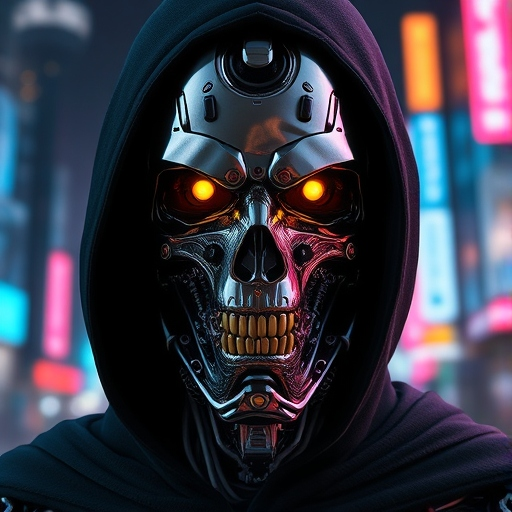

In [2]:
Image(filename = 'RENN.jpeg')

# Reverse Engineering a Neural Network

#### This lecture, inspired by Andrej Karpathy’s MicroGrad framework, takes a deep dive into constructing a Neural Network from the ground up. We will build both feed-forward and backpropagation layers, starting from first principles to manually derive and compute gradients. As we progress, we will automate the backpropagation process, incorporate the hyperbolic tangent (TANH) activation function, and explore its role in nonlinear transformations. Finally, we will bridge the gap to modern frameworks by integrating a PyTorch model and showcasing the power of gradient descent to systematically minimize loss, providing a comprehensive understanding of the mechanics and mathematics behind neural networks.

### [original video from Andrej Karpathy](https://youtu.be/VMj-3S1tku0?si=-Tzz2Y2-iv5FLDtY)

#### Credit: [Andrej Karpathy](mailto:karpathy@eurekalabs.ai)
#### Instructor: [Kevin Thomas](mailto:ket189@pitt.edu)

## Imports

In [2]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Manual Feed-Foward Neural Network (1st Epoch NO ACTIVATION FUNCTION)

In [3]:
class SimpleValue:
    """
    A simple class to represent a value in a computational graph.

    Attributes:
        data (float): The value of the node.
        label (str): An optional label for the node.
    """
    def __init__(self, data, label=''):
        """
        Initializes a SimpleValue object.

        Args:
            data (float): The value of the node.
            label (str, optional): An optional label for the node. Defaults to ''.
        """
        self.data = data
        self.label = label

    def __add__(self, other):
        """
        Adds this value to another SimpleValue.

        Args:
            other (SimpleValue): The other value to add.

        Returns:
            SimpleValue: A new SimpleValue representing the sum of this value and the other value.
                         The label of the new value is constructed as `(<this_label> + <other_label>)`.

        Example:
            >>> a = SimpleValue(2.0, label='a')
            >>> b = SimpleValue(3.0, label='b')
            >>> c = a + b
            >>> print(c)
            SimpleValue(data=5.0, label='(a + b)')
        """
        return SimpleValue(self.data + other.data, label=f'({self.label} + {other.label})')

    def __mul__(self, other):
        """
        Multiplies this value by another SimpleValue.

        Args:
            other (SimpleValue): The other value to multiply.

        Returns:
            SimpleValue: A new SimpleValue representing the product of this value and the other value.
                         The label of the new value is constructed as `(<this_label> * <other_label>)`.

        Example:
            >>> a = SimpleValue(2.0, label='a')
            >>> b = SimpleValue(3.0, label='b')
            >>> c = a * b
            >>> print(c)
            SimpleValue(data=6.0, label='(a * b)')
        """
        return SimpleValue(self.data * other.data, label=f'({self.label} * {other.label})')

    def __repr__(self):
        """
        Returns a string representation of the SimpleValue object.

        Returns:
            str: A string in the format `SimpleValue(data=<data>, label='<label>')`.

        Example:
            >>> a = SimpleValue(2.0, label='a')
            >>> print(a)
            SimpleValue(data=2.0, label='a')
        """
        return f'SimpleValue(data={self.data}, label=\'{self.label}\')'


class FeedForwardNN:
    """
    A simple feed-forward neural network implemented using the SimpleValue class.

    This network performs three sequential computations:
    - Layer 1: Computes the intermediate value `e` based on inputs `a` and `b`.
    - Layer 2: Computes the intermediate value `d` based on `e` and input `c`.
    - Layer 3: Computes the output `L` based on `d` and input `f`.

    The network supports gradient-based computations through backpropagation.
    """
    def __init__(self):
        """
        Initializes the feed-forward neural network.

        Attributes:
            a (SimpleValue): Input node with an initial value of 2.0.
            b (SimpleValue): Input node with an initial value of -3.0.
            c (SimpleValue): Input node with an initial value of 10.0.
            f (SimpleValue): Constant input for the final layer with a value of -2.0.
            w1 (SimpleValue): Weight for computing `e` (default: 1.0).
            b1 (SimpleValue): Bias for computing `e` (default: 0.0).
            w2 (SimpleValue): Weight for computing `d` (default: 1.0).
            b2 (SimpleValue): Bias for computing `d` (default: 0.0).
            w3 (SimpleValue): Weight for computing `L` (default: 1.0).
            b3 (SimpleValue): Bias for computing `L` (default: 0.0).
        """
        # define the input nodes as SimpleValues
        self.a = SimpleValue(2.0, label='a')
        self.b = SimpleValue(-3.0, label='b')
        self.c = SimpleValue(10.0, label='c')
        
        # define weights and biases for layers
        self.w1 = SimpleValue(1.0, label='w1')  # weight for e = a * b
        self.b1 = SimpleValue(0.0, label='b1')  # bias for e
        self.w2 = SimpleValue(1.0, label='w2')  # weight for d = e + c
        self.b2 = SimpleValue(0.0, label='b2')  # bias for d
        self.w3 = SimpleValue(1.0, label='w3')  # weight for L = d * f
        self.b3 = SimpleValue(0.0, label='b3')  # bias for L
        
        # define additional constant input
        self.f = SimpleValue(-2.0, label='f')  # Constant input for final layer
        
    def forward(self):
        """
        Performs the forward pass of the network to compute the output `L`.

        Computation steps:
        - Layer 1: Computes `e = w1 * (a * b) + b1`.
        - Layer 2: Computes `d = w2 * (e + c) + b2`.
        - Layer 3: Computes `L = w3 * (d * f) + b3`.

        Returns:
            SimpleValue: The output `L` of the network.
        """
        # layer 1: compute e = w1 * (a * b) + b1
        e_intermediate = self.a * self.b  # Compute a * b
        self.e = (e_intermediate * self.w1) + self.b1  # Scale by w1 and add bias
        self.e.label = 'e'
        
        # layer 2: compute d = w2 * (e + c) + b2
        d_intermediate = self.e + self.c  # Compute e + c
        self.d = (d_intermediate * self.w2) + self.b2  # Scale by w2 and add bias
        self.d.label = 'd'
        
        # layer 3: compute L = w3 * (d * f) + b3
        L_intermediate = self.d * self.f  # Compute d * f
        self.L = (L_intermediate * self.w3) + self.b3  # Scale by w3 and add bias
        self.L.label = 'L'

        # return L
        return self.L
    
    def parameters(self):
        """
        Returns all weights and biases of the neural network.

        Returns:
            list[SimpleValue]: A list of all `SimpleValue` objects representing the weights and biases.
        """
        # return all weights and biases
        return [self.w1, self.b1, self.w2, self.b2, self.w3, self.b3]

In [4]:
# create the feed-forward neural network
nn = FeedForwardNN()

# perform a forward pass
output = nn.forward()

# print intermediate and final outputs
print(f'a = {nn.a}')
print(f'b = {nn.b}')
print(f'c = {nn.c}')
print(f'e = {nn.e}')
print(f'd = {nn.d}')
print(f'f = {nn.f}')
print(f'L = {nn.L}')

# verify the parameters
print('\nParameters:')
for parameter in nn.parameters():
    print(f'{parameter.label}: {parameter.data}')

a = SimpleValue(data=2.0, label='a')
b = SimpleValue(data=-3.0, label='b')
c = SimpleValue(data=10.0, label='c')
e = SimpleValue(data=-6.0, label='e')
d = SimpleValue(data=4.0, label='d')
f = SimpleValue(data=-2.0, label='f')
L = SimpleValue(data=-8.0, label='L')

Parameters:
w1: 1.0
b1: 0.0
w2: 1.0
b2: 0.0
w3: 1.0
b3: 0.0


## Manual Back Propogation Neural Network (1st Epoch)

In [6]:
class Value:
    """
    A class representing a scalar value in a computational graph.

    This class supports operations such as addition, subtraction, multiplication, 
    division, exponentiation, and hyperbolic tangent (tanh), along with automatic 
    differentiation through backpropagation. It is designed to build and manipulate 
    computational graphs for neural network computations.
    
    Attributes:
        data (float): The scalar value this object holds.
        grad (float): The gradient of this value with respect to some scalar loss.
        _backward (function): A function to compute the local gradient contribution during backpropagation.
        _prev (set[Value]): The set of `Value` objects that are inputs to this value.
        _op (str): The operation that produced this value (e.g., '+', '*', 'tanh', '**').
        label (str): A label for identifying the value (useful for visualization and debugging).
    """

    def __init__(self, data, _children=(), _op='', label=''):
        """
        Initializes a `Value` object.

        Args:
            data (float): The scalar value to store.
            _children (tuple[Value], optional): The `Value` objects used to produce this value. Default is an empty tuple.
            _op (str, optional): The operation that produced this value. Default is an empty string.
            label (str, optional): A label for this value. Default is an empty string.
        """
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        """
        Returns a string representation of the `Value` object.

        Returns:
            str: A string showing the data value.
        """
        return f'Value(data={self.data})'
    
    def __add__(self, other):
        """
        Defines the addition operation for `Value` objects.

        Args:
            other (Value): The other `Value` object to add.

        Returns:
            Value: A new `Value` object representing the sum of the two values.

        Note:
            The `_backward` method for the resulting value calculates the gradient contributions
            to both operands of the addition.
        """
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out

    def __mul__(self, other):
        """
        Defines the multiplication operation for `Value` objects.

        Args:
            other (Value): The other `Value` object to multiply.

        Returns:
            Value: A new `Value` object representing the product of the two values.

        Note:
            The `_backward` method for the resulting value calculates the gradient contributions
            to both operands of the multiplication.
        """
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out

    def __pow__(self, other):
        """
        Defines the power operation for `Value` objects.

        Args:
            other (int or float): The exponent to which the value is raised.

        Returns:
            Value: A new `Value` object representing the value raised to the power of `other`.

        Note:
            The `_backward` method for the resulting value calculates the gradient contribution
            for the power operation.
        """
        assert isinstance(other, (int, float)), 'only supporting int/float powers for now'
        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        
        return out

    def __rmul__(self, other):
        """
        Defines right-side multiplication for `Value` objects.

        Args:
            other (float or Value): The value to multiply from the right.

        Returns:
            Value: A new `Value` object representing the product.
        """
        return self * other

    def __truediv__(self, other):
        """
        Defines division operation for `Value` objects.

        Args:
            other (Value): The divisor `Value` object.

        Returns:
            Value: A new `Value` object representing the division.

        Note:
            This is implemented as multiplying by the reciprocal.
        """
        return self * other**-1

    def __neg__(self):
        """
        Defines the negation operation for a `Value` object.

        Returns:
            Value: A new `Value` object representing the negated value.
        """
        return self * -1

    def __sub__(self, other):
        """
        Defines the subtraction operation for `Value` objects.

        Args:
            other (Value): The other `Value` object to subtract.

        Returns:
            Value: A new `Value` object representing the difference.
        """
        return self + (-other)

    def __radd__(self, other):
        """
        Defines right-side addition for `Value` objects.

        Args:
            other (float or Value): The value to add from the right.

        Returns:
            Value: A new `Value` object representing the sum.
        """
        return self + other

    def tanh(self):
        """
        Applies the hyperbolic tangent (tanh) function to the value.

        Returns:
            Value: A new `Value` object representing the tanh of this value.

        Note:
            The `_backward` method for the resulting value calculates the gradient contribution
            for the tanh function: `(1 - tanh(x)^2)`.
        """
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out

    def exp(self):
        """
        Applies the exponential function to the value.

        Returns:
            Value: A new `Value` object representing the exponential of this value.

        Note:
            The `_backward` method for the resulting value calculates the gradient contribution
            for the exponential function: `e^x`.
        """
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out

    def backward(self):
        """
        Performs backpropagation to calculate gradients for all `Value` objects in the computational graph.

        This method starts from the current `Value` object (usually the loss in a neural network) and
        propagates gradients to all dependent `Value` objects by traversing the computational graph in
        reverse topological order.

        Note:
            Sets the gradient of the starting value to 1.0 (i.e., the gradient of itself).
        """
        topo = []  # topological order of nodes
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [7]:
import platform

In [8]:
# check if the OS is macOS
if platform.system() == 'Darwin':
    !pip install graphviz

In [9]:
from graphviz import Digraph

In [10]:
def trace(root):
    """
    Traces the computational graph starting from the given root node.

    This function builds a set of all nodes and edges in the computational graph
    by traversing backwards from the root node. It identifies all intermediate
    `Value` objects (nodes) and their relationships (edges) in the graph.

    Args:
        root (Value): The root node of the computational graph, typically the final output
                     (e.g., a loss value in a neural network).

    Returns:
        tuple:
            - nodes (set[Value]): A set of all `Value` objects in the computational graph.
            - edges (set[tuple[Value, Value]]): A set of directed edges representing the
              parent-child relationships in the graph.
    """
    nodes, edges = set(), set()
    
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    
    build(root)
    
    return nodes, edges


def draw_dot(root):
    """
    Creates a visual representation of the computational graph using the `graphviz` library.

    This function generates a directed graph (in DOT format) of the computational graph
    starting from the root node. Each node represents a `Value` object, and edges represent
    the operations connecting them.

    Args:
        root (Value): The root node of the computational graph, typically the final output
                     (e.g., a loss value in a neural network).

    Returns:
        graphviz.Digraph: A directed graph object representing the computational graph.

    Example:
        >>> from graphviz import Digraph
        >>> a = Value(2.0, label='a')
        >>> b = Value(-3.0, label='b')
        >>> c = Value(10.0, label='c')
        >>> e = a * b; e.label = 'e'
        >>> d = e + c; d.label = 'd'
        >>> f = Value(-2.0, label='f')
        >>> L = d * f; L.label = 'L'
        >>> dot = draw_dot(L)
        >>> dot.render('graph', format='svg', cleanup=True)
    """
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right graph direction
    
    nodes, edges = trace(root)  # Trace the computational graph
    
    for n in nodes:
        uid = str(id(n))
        # for each value in the graph, create a rectangular ('record') node
        dot.node(
            name=uid,
            label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad),
            shape='record'
        )
        if n._op:
            # if the value is a result of an operation, create an operation node
            dot.node(name=uid + n._op, label=n._op)
            # connect the operation node to the value node
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        # connect n1 (input) to the operation node of n2 (output)
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

### Manual Feed-Foward (1st Epoch NO ACTIVATION FUNCTION)

In [11]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

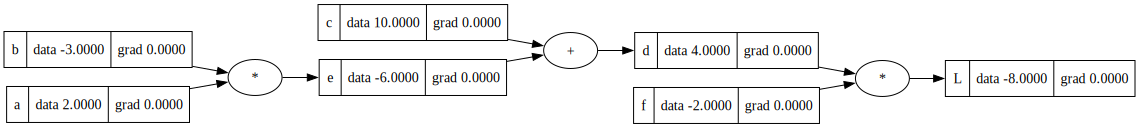

In [12]:
draw_dot(L)

In [13]:
# a.data += 0.01 * a.grad
# b.data += 0.01 * b.grad
# c.data += 0.01 * c.grad
# f.data += 0.01 * f.grad

# e = a * b
# d = e + c
# L = d * f

# print(L.data)

# -8.0

What is the derivative of `L` with respect to `L`? If we change `L` by a tiny amount `h`, how much does `L` change?

In [14]:
def calc_l_grad():
    """
    Demonstrates numerical gradient computation for a simple computational graph.

    This function creates a computational graph using the `Value` class to compute
    a scalar output `L` based on inputs `a`, `b`, `c`, and `f`. It approximates the
    gradient of `L` using the difference quotient formula by adding a small increment `h`
    to the final output `L`.

    Computational Steps:
    - The graph calculates `L` as:
      - `e = a * b`
      - `d = e + c`
      - `L = d * f`
    - The gradient of `L` is approximated as:
      - `(L2 - L1) / h`, where:
        - `L1`: Original value of `L`.
        - `L2`: Value of `L` after adding a small increment `h`.

    Note:
        The function currently adds `h` directly to `L` in the second computation for demonstration
        purposes. This is not a true partial derivative with respect to a specific input.

    Returns:
        None: The function prints the numerical gradient approximation.

    Example:
        >>> lol()
        Prints the numerical gradient approximation for the computational graph.
    """
    h = 0.001  # increment step

    # first computation (original L)
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data  # original output

    # second computation (L with added h)
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data + h  # increment the final output

    # print numerical gradient approximation
    print((L2 - L1) / h)


calc_l_grad()

1.000000000000334


#### dL/dL

In [15]:
L.grad = 1.0

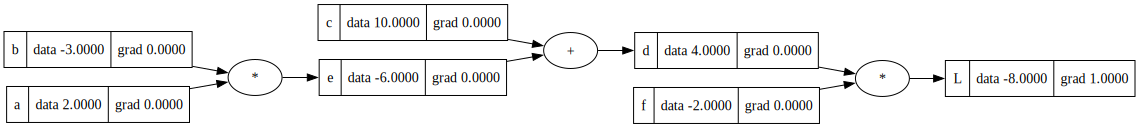

In [16]:
draw_dot(L)

#### L = d * f
#### dL/dd = f
#### (f(x+h) - f(x)) / h
#### ((d+h) * f - d * f) / h 
#### (d * f + h * f - d * f) / h
#### (h * f) / h
#### f

### Explanation of the Computation

#### 1. **Forward Computation**
- The operation is defined as: 
  $L = d \cdot f$
- The values are:
  - $d = 4.0$
  - $f = -2.0$
- Substituting these values:
  $$
  L = 4.0 \cdot (-2.0) = -8.0
  $$

This is the forward pass, where the network propagates inputs through the computational graph to calculate the output $L$.

---

#### 2. **Backward Computation**
The backward pass calculates how changes in $d$ and $f$ affect the output $L$. This is done by computing partial derivatives (gradients).

##### Gradient of $L$ with respect to $d$ ($\frac{\partial L}{\partial d}$):
- From $L = d \cdot f$, we differentiate with respect to $d$:
  $$
  \frac{\partial L}{\partial d} = f
  $$
- Substituting $f = -2.0$:
  $$
  \frac{\partial L}{\partial d} = -2.0
  $$

##### Gradient of $L$ with respect to $f$ ($\frac{\partial L}{\partial f}$):
- Similarly, from $L = d \cdot f$, we differentiate with respect to $f$:
  $$
  \frac{\partial L}{\partial f} = d
  $$
- Substituting $d = 4.0$:
  $$
  \frac{\partial L}{\partial f} = 4.0
  $$

---

#### 3. **Gradient Verification**
Using the numerical approximation of derivatives:
$$
\frac{\partial L}{\partial d} \approx \frac{L(d + h, f) - L(d, f)}{h}
$$
Let’s verify for $h$ being a small value (e.g., $h = 0.001$):

1. Compute $L(d + h, f)$:
   $$
   L(d + h, f) = (4.0 + 0.001) \cdot -2.0 = -8.002
   $$
2. Compute $L(d, f)$:
   $$
   L(d, f) = -8.0
   $$
3. Approximate $\frac{\partial L}{\partial d}$:
   $$
   \frac{\partial L}{\partial d} \approx \frac{-8.002 - (-8.0)}{0.001} = -2.0
   $$

This matches the analytic result.

Similarly, we can verify $\frac{\partial L}{\partial f}$ using:
$$
\frac{\partial L}{\partial f} \approx \frac{L(d, f + h) - L(d, f)}{h}
$$

---

#### 4. **Key Takeaways**
- **Forward Pass**: Computes $L = d \cdot f$ based on the inputs $d$ and $f$.
- **Backward Pass**: Uses derivatives to calculate how changes in $d$ and $f$ affect $L$:
  - $\frac{\partial L}{\partial d} = f$
  - $\frac{\partial L}{\partial f} = d$
- **Numerical Approximation**: Confirms the correctness of gradients computed during backpropagation using small perturbations.

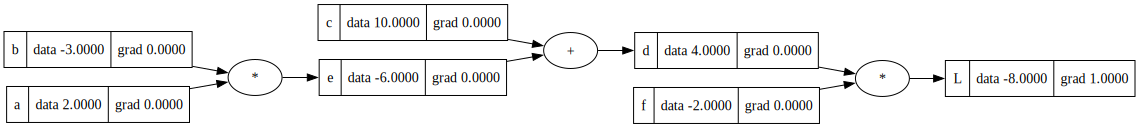

In [17]:
draw_dot(L)

In [18]:
def calc_f_grad():
    """
    Demonstrates numerical gradient computation for a simple computational graph.

    This function builds a computational graph using the `Value` class and calculates
    a scalar output `L` based on the inputs `a`, `b`, `c`, and `f`. it approximates the
    gradient of `L` with respect to `f` using the difference quotient formula.

    Computational steps:
    - the graph computes `L` using the following:
      - `e = a * b`
      - `d = e + c`
      - `L = d * f`
    - the numerical gradient is approximated as:
      - `(L2 - L1) / h`, where:
        - `L1`: value of `L` with original `f`
        - `L2`: value of `L` with `f` incremented by `h`

    Returns:
        none: prints the numerical gradient approximation with respect to `f`

    Example:
        >>> lol()
        prints the numerical gradient approximation for `L` with respect to `f`
    """
    h = 0.001  # small step for numerical gradient approximation

    # first computation (original value of L)
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b  # compute e = a * b
    e.label = 'e'
    d = e + c  # compute d = e + c
    d.label = 'd'
    f = Value(-2.0, label='f')  # define f
    L = d * f  # compute L = d * f
    L.label = 'L'
    L1 = L.data  # store the original value of L

    # second computation (increment f by h)
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b  # compute e = a * b
    e.label = 'e'
    d = e + c  # compute d = e + c
    d.label = 'd'
    f = Value(-2.0 + h, label='f')  # increment f by h
    L = d * f  # compute L = d * f with updated f
    L.label = 'L'
    L2 = L.data  # store the new value of L

    # print the numerical gradient approximation
    print((L2 - L1) / h)


calc_f_grad()

3.9999999999995595


#### dL/df

In [19]:
f.grad = 4.0

In [20]:
def calc_d_grad():
    """
    Demonstrates numerical gradient computation for a simple computational graph

    This function builds a computational graph using the `Value` class to compute
    a scalar output `L` based on inputs `a`, `b`, `c`, and `f`. it approximates the
    gradient of `L` with respect to `d` using the difference quotient formula.

    Computational steps:
    - the graph computes `L` using the following:
      - `e = a * b`
      - `d = e + c`
      - `L = d * f`
    - the numerical gradient is approximated as:
      - `(L2 - L1) / h`, where:
        - `L1`: value of `L` with original `d`
        - `L2`: value of `L` with `d` incremented by `h`

    Returns:
        none: prints the numerical gradient approximation with respect to `d`

    Example:
        >>> lol()
        prints the numerical gradient approximation for `L` with respect to `d`
    """
    h = 0.001  # small step for numerical gradient approximation

    # first computation (original value of L)
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b  # compute e = a * b
    e.label = 'e'
    d = e + c  # compute d = e + c
    d.label = 'd'
    f = Value(-2.0, label='f')  # define f
    L = d * f  # compute L = d * f
    L.label = 'L'
    L1 = L.data  # store the original value of L

    # second computation (increment d by h)
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b  # compute e = a * b
    e.label = 'e'
    d = Value(e.data + c.data + h, label='d')  # increment d by h
    f = Value(-2.0, label='f')  # define f
    L = d * f  # compute L = d * f with updated d
    L.label = 'L'
    L2 = L.data  # store the new value of L

    # print the numerical gradient approximation
    print((L2 - L1) / h)


calc_d_grad()

-2.000000000000668


#### dL/dd

In [21]:
d.grad = -2.0

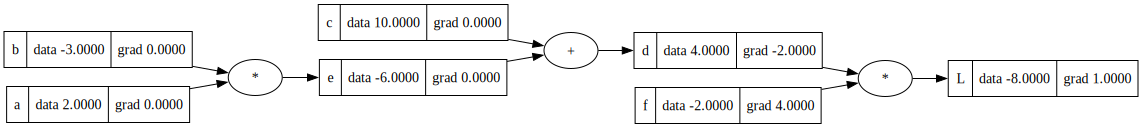

In [22]:
draw_dot(L)

#### dd/dc = 1.0
#### d = c + e
#### (f(x+h) - f(x)) / h
#### ((c+h + e) - (c + e)) / h
#### (c + h + e - c - e) / h
#### h/h

## Explanation of the Gradient $\frac{\partial d}{\partial c}$

### 1. **Forward Computation**
The operation for $d$ is defined as:
$$
d = c + e
$$
Where:
- $c$ is the input value.
- $e$ is the intermediate value.

---

### 2. **Gradient of $d$ with Respect to $c$**
To compute $\frac{\partial d}{\partial c}$, we differentiate $d = c + e$ with respect to $c$:
$$
\frac{\partial d}{\partial c} = 1
$$

---

### 3. **Verification via Numerical Approximation**
Using the numerical approximation for derivatives:
$$
\frac{\partial d}{\partial c} \approx \frac{d(c + h, e) - d(c, e)}{h}
$$

Substitute the definition of $d$ into the equation:
$$
\frac{\partial d}{\partial c} \approx \frac{(c + h + e) - (c + e)}{h}
$$

Simplify the terms:
$$
\frac{\partial d}{\partial c} \approx \frac{c + h + e - c - e}{h}
$$

Cancel out $c$ and $e$:
$$
\frac{\partial d}{\partial c} \approx \frac{h}{h}
$$

Simplify further:
$$
\frac{\partial d}{\partial c} \approx 1
$$

This confirms that $\frac{\partial d}{\partial c} = 1$ is correct.

---

### 4. **Key Insight**
The derivative $\frac{\partial d}{\partial c} = 1$ arises because $c$ contributes linearly to $d$ with no scaling factor or additional operations.

#### dd/de = 1.0 (by symmetry)

#### The local derivative is a small node embedded within the larger graph. 
#### The `+` node has no knowledge on the rest of the graph.
#### It knows it took a `c` and an `e` and added them and created `d`.
#### The `+` node also knows the local derivative of dd/dc and dd/de which is 1.
#### We want dL/dc.

#### WANT:
#### dL/dc = (dL/dd) * (dd/dc)
#### dL/dc = (dL/dd) * 1
#### KNOW:
#### dL/dd
#### dd/dc

## Explanation of the Chain Rule and $\frac{\partial L}{\partial c}$
Here we explain the chain rule and proving how $\frac{\partial L}{\partial c}$ occurs through $c$ and $e$.

### 1. **What is the Chain Rule?**

The **chain rule** is a fundamental concept in calculus used to compute the derivative of a composite function. If a variable $z$ depends on $y$, and $y$ depends on $x$, then the derivative of $z$ with respect to $x$ is computed as:

$$
\frac{\partial z}{\partial x} = \frac{\partial z}{\partial y} \cdot \frac{\partial y}{\partial x}
$$

This allows gradients to propagate backward through intermediate variables in a computational graph.

---

### 2. **The Computational Graph**

The relationships in the graph are:
- $d = c + e$
- $L = d \cdot f$

Here, $c$ directly contributes to $d$, and $d$ contributes to $L$. The gradient $\frac{\partial L}{\partial c}$ must account for both contributions using the chain rule.

---

### 3. **Gradient $\frac{\partial L}{\partial c}$**

To compute $\frac{\partial L}{\partial c}$, we apply the chain rule:

$$
\frac{\partial L}{\partial c} = \frac{\partial L}{\partial d} \cdot \frac{\partial d}{\partial c}
$$

#### Step 1: Compute $\frac{\partial d}{\partial c}$
From the equation $d = c + e$, the derivative with respect to $c$ is:

$$
\frac{\partial d}{\partial c} = 1
$$

#### Step 2: Compute $\frac{\partial L}{\partial d}$
From the equation $L = d \cdot f$, the derivative with respect to $d$ is:

$$
\frac{\partial L}{\partial d} = f
$$

Substituting $f = -2.0$, we get:

$$
\frac{\partial L}{\partial d} = -2.0
$$

#### Step 3: Combine Using the Chain Rule
Now, substitute the values into the chain rule:

$$
\frac{\partial L}{\partial c} = \frac{\partial L}{\partial d} \cdot \frac{\partial d}{\partial c}
$$

Substitute $\frac{\partial L}{\partial d} = -2.0$ and $\frac{\partial d}{\partial c} = 1$:

$$
\frac{\partial L}{\partial c} = (-2.0) \cdot (1) = -2.0
$$

---

### 4. **Interpretation**

The gradient $\frac{\partial L}{\partial c} = -2.0$ tells us how much a small change in $c$ affects the final output $L$. This is achieved by following the path of dependencies:
- $c$ affects $d$ via $d = c + e$.
- $d$ affects $L$ via $L = d \cdot f$.

The chain rule combines these contributions to compute the total effect.

---

### 5. **Key Takeaway**
The chain rule is essential in neural networks to compute gradients through multiple layers or variables. It ensures that the effect of each variable is propagated backward through the computational graph.

In [23]:
def calc_c_grad():
    """
    Demonstrates numerical gradient computation for a simple computational graph

    This function constructs a computational graph using the `Value` class to compute
    a scalar output `L` based on the inputs `a`, `b`, `c`, and `f`. it approximates the
    gradient of `L` with respect to `c` using the difference quotient formula.

    Computational steps:
    - the graph computes `L` using the following:
      - `e = a * b`
      - `d = e + c`
      - `L = d * f`
    - the numerical gradient is approximated as:
      - `(L2 - L1) / h`, where:
        - `L1`: value of `L` with original `c`
        - `L2`: value of `L` with `c` incremented by `h`

    Returns:
        none: prints the numerical gradient approximation with respect to `c`

    Example:
        >>> lol()
        prints the numerical gradient approximation for `L` with respect to `c`
    """
    h = 0.001  # small step for numerical gradient approximation

    # first computation (original value of L)
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')  # original value of c
    e = a * b  # compute e = a * b
    e.label = 'e'
    d = e + c  # compute d = e + c
    d.label = 'd'
    f = Value(-2.0, label='f')  # define f
    L = d * f  # compute L = d * f
    L.label = 'L'
    L1 = L.data  # store the original value of L

    # second computation (increment c by h)
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0 + h, label='c')  # increment c by h
    e = a * b  # compute e = a * b
    e.label = 'e'
    d = e + c  # compute d = e + updated c
    d.label = 'd'
    f = Value(-2.0, label='f')  # define f
    L = d * f  # compute L = d * f with updated c
    L.label = 'L'
    L2 = L.data  # store the new value of L

    # print the numerical gradient approximation
    print((L2 - L1) / h)


calc_c_grad()

-1.9999999999988916


#### dL/dc

In [24]:
c.grad = -2.0

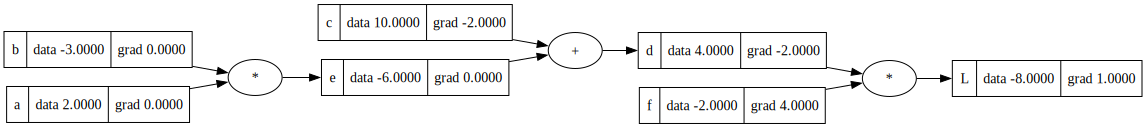

In [25]:
draw_dot(L)

In [26]:
def calc_e_grad():
    """
    Demonstrates numerical gradient computation for a simple computational graph

    This function constructs a computational graph using the `Value` class to compute
    a scalar output `L` based on the inputs `a`, `b`, `c`, and `f`. it approximates the
    gradient of `L` with respect to `e` using the difference quotient formula.

    Computational steps:
    - the graph computes `L` using the following:
      - `e = a * b`
      - `d = e + c`
      - `L = d * f`
    - the numerical gradient is approximated as:
      - `(L2 - L1) / h`, where:
        - `L1`: value of `L` with original `e`
        - `L2`: value of `L` with `e` incremented by `h`

    Returns:
        none: prints the numerical gradient approximation with respect to `e`

    Example:
        >>> lol()
        prints the numerical gradient approximation for `L` with respect to `e`
    """
    h = 0.001  # small step for numerical gradient approximation

    # first computation (original value of L)
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b  # compute e = a * b
    e.label = 'e'
    d = e + c  # compute d = e + c
    d.label = 'd'
    f = Value(-2.0, label='f')  # define f
    L = d * f  # compute L = d * f
    L.label = 'L'
    L1 = L.data  # store the original value of L

    # second computation (increment e by h)
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b + Value(h)  # increment e by h
    e.label = 'e'
    d = e + c  # compute d = e + c
    d.label = 'd'
    f = Value(-2.0, label='f')  # define f
    L = d * f  # compute L = d * f with updated e
    L.label = 'L'
    L2 = L.data  # store the new value of L

    # print the numerical gradient approximation
    print((L2 - L1) / h)


calc_e_grad()

-2.000000000000668


#### dL/de

In [27]:
e.grad = -2.0

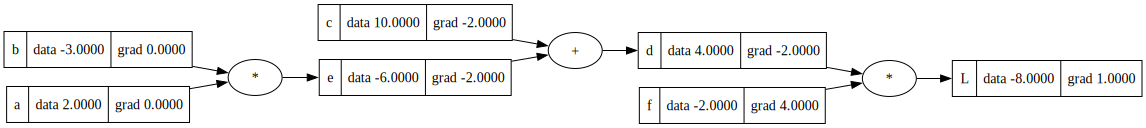

In [28]:
draw_dot(L)

#### dL/da = (dL/de) * (de/da)
#### dL/db = (dL/de) * (de/db)
#### e = a * b
#### de/da = b
#### a.grad = (-2.0 * -3.0)
#### b.grad = (-2.0 * 2.0)

#### The local derivative is a small node embedded within the larger graph. 
#### The `*` node has no knowledge of the rest of the graph.
#### It knows it took an `e` and an `a`, multiplied them, and created `b`.
#### The `*` node also knows the local derivatives of db/de and db/da, which are `a` and `e`, respectively.
#### We want dL/de.

### Backpropagation and Gradient Computation Explanation

#### 1. Chain Rule for Gradients
To compute the gradient of the output `L` with respect to the input `a`, we use the **chain rule**:

$$
\frac{\partial L}{\partial a} = \frac{\partial L}{\partial e} \cdot \frac{\partial e}{\partial a}
$$

Similarly, the gradient of `L` with respect to `b` is:

$$
\frac{\partial L}{\partial b} = \frac{\partial L}{\partial e} \cdot \frac{\partial e}{\partial b}
$$

---

#### 2. Relationships in the Graph
- From the computational graph:
  - $e = a \cdot b$ (multiplication operation)
  - Gradients of multiplication:
    - $\frac{\partial e}{\partial a} = b$
    - $\frac{\partial e}{\partial b} = a$

---

#### 3. Computing Gradients Step by Step

##### **Step 1: Gradient of `L` with respect to `e`**
From the graph:
- $\frac{\partial L}{\partial e} = -2.0$

##### **Step 2: Gradient of `e` with respect to `a`**
- $\frac{\partial e}{\partial a} = b = -3.0$

##### **Step 3: Gradient of `L` with respect to `a`**
Using the chain rule:
$$
\frac{\partial L}{\partial a} = \frac{\partial L}{\partial e} \cdot \frac{\partial e}{\partial a}
$$
Substitute the values:
$$
\frac{\partial L}{\partial a} = (-2.0) \cdot (-3.0) = 6.0
$$
Thus:
$$
a.\text{grad} = 6.0
$$

##### **Step 4: Gradient of `e` with respect to `b`**
- $\frac{\partial e}{\partial b} = a = 2.0$

##### **Step 5: Gradient of `L` with respect to `b`**
Using the chain rule:
$$
\frac{\partial L}{\partial b} = \frac{\partial L}{\partial e} \cdot \frac{\partial e}{\partial b}
$$
Substitute the values:
$$
\frac{\partial L}{\partial b} = (-2.0) \cdot (2.0) = -4.0
$$
Thus:
$$
b.\text{grad} = -4.0
$$

---

#### 4. Final Gradients
- $a.\text{grad} = 6.0$
- $b.\text{grad} = -4.0$

These gradients indicate how a small change in `a` or `b` will affect the final output `L`.

In [29]:
def calc_a_grad():
    """
    Demonstrates numerical gradient computation of L with respect to a.

    This function constructs a computational graph using the `Value` class to compute
    a scalar output `L` based on the inputs `a`, `b`, `c`, and `f`. It approximates the
    gradient of `L` with respect to `a` using the difference quotient formula.

    Computational steps:
    - the graph computes `L` using the following:
      - `e = a * b`
      - `d = e + c`
      - `L = d * f`
    - the numerical gradient is approximated as:
      - `(L2 - L1) / h`, where:
        - `L1`: value of `L` with original `a`
        - `L2`: value of `L` with `a` incremented by `h`

    Returns:
        none: prints the numerical gradient approximation with respect to `a`

    Example:
        >>> lol_a()
        prints the numerical gradient approximation for `L` with respect to `a`
    """
    h = 0.001  # small step for numerical gradient approximation

    # first computation (original value of L)
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b  # compute e = a * b
    e.label = 'e'
    d = e + c  # compute d = e + c
    d.label = 'd'
    f = Value(-2.0, label='f')  # define f
    L = d * f  # compute L = d * f
    L.label = 'L'
    L1 = L.data  # store the original value of L

    # second computation (increment a by h)
    a = Value(2.0 + h, label='a')  # increment a by h
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b  # compute e = a * b
    e.label = 'e'
    d = e + c  # compute d = e + c
    d.label = 'd'
    f = Value(-2.0, label='f')  # define f
    L = d * f  # compute L = d * f with updated a
    L.label = 'L'
    L2 = L.data  # store the new value of L

    # print the numerical gradient approximation
    print((L2 - L1) / h)


calc_a_grad()

6.000000000000227


#### dL/da

In [30]:
a.grad = 6.0

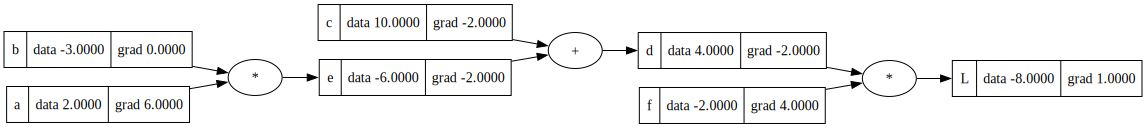

In [31]:
draw_dot(L)

In [32]:
def calc_b_grad():
    """
    Demonstrates numerical gradient computation of L with respect to b.

    This function constructs a computational graph using the `Value` class to compute
    a scalar output `L` based on the inputs `a`, `b`, `c`, and `f`. It approximates the
    gradient of `L` with respect to `b` using the difference quotient formula.

    Computational steps:
    - the graph computes `L` using the following:
      - `e = a * b`
      - `d = e + c`
      - `L = d * f`
    - the numerical gradient is approximated as:
      - `(L2 - L1) / h`, where:
        - `L1`: value of `L` with original `b`
        - `L2`: value of `L` with `b` incremented by `h`

    Returns:
        none: prints the numerical gradient approximation with respect to `b`

    Example:
        >>> lol_b()
        prints the numerical gradient approximation for `L` with respect to `b`
    """
    h = 0.001  # small step for numerical gradient approximation

    # first computation (original value of L)
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b  # compute e = a * b
    e.label = 'e'
    d = e + c  # compute d = e + c
    d.label = 'd'
    f = Value(-2.0, label='f')  # define f
    L = d * f  # compute L = d * f
    L.label = 'L'
    L1 = L.data  # store the original value of L

    # second computation (increment b by h)
    a = Value(2.0, label='a')
    b = Value(-3.0 + h, label='b')  # increment b by h
    c = Value(10.0, label='c')
    e = a * b  # compute e = a * b
    e.label = 'e'
    d = e + c  # compute d = e + c
    d.label = 'd'
    f = Value(-2.0, label='f')  # define f
    L = d * f  # compute L = d * f with updated b
    L.label = 'L'
    L2 = L.data  # store the new value of L

    # print the numerical gradient approximation
    print((L2 - L1) / h)


calc_b_grad()

-3.9999999999995595


#### dL/db

In [33]:
b.grad = -4.0

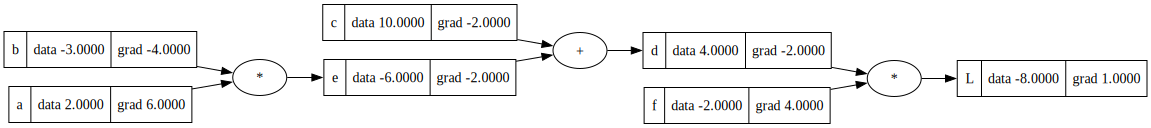

In [34]:
draw_dot(L)

### Manual Optimization

#### Manually Optimize

In [35]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

#### Manual Feed-Foward (1st Epoch NO ACTIVATION FUNCTION)

In [36]:
e = a * b
d = e + c
L = d * f
L.data

-7.286496

## More Sophisticated Example w/ TANH Activation Function

### TANH Activation Function (-1 to 1)

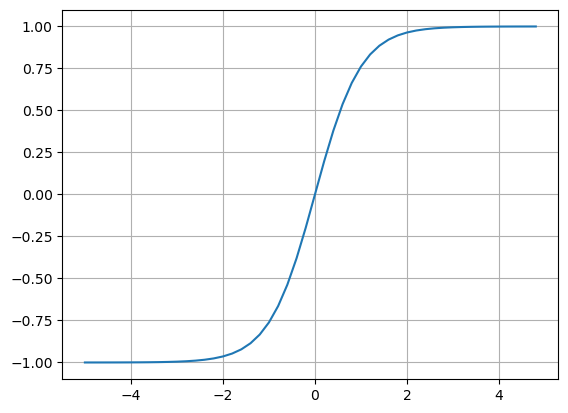

In [37]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid()
plt.show()

### Manual Feed-Foward (1st Epoch)

In [38]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# activation function
o = n.tanh(); o.label = 'o'

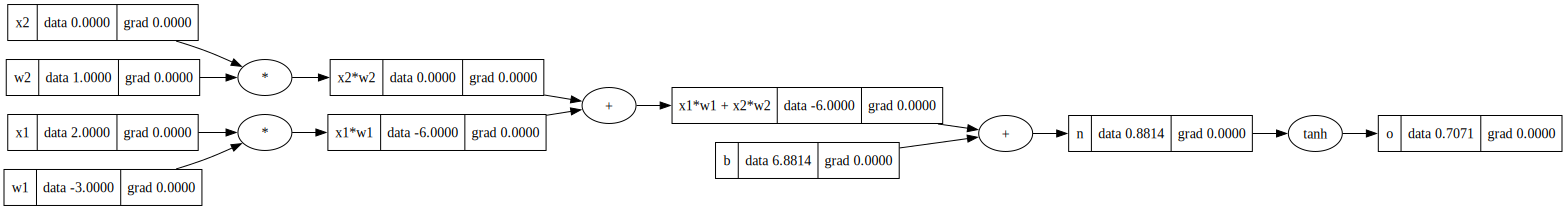

In [39]:
draw_dot(o)

### Manual Back Propogation (1st Epoch)

In [40]:
o.grad = 1.0

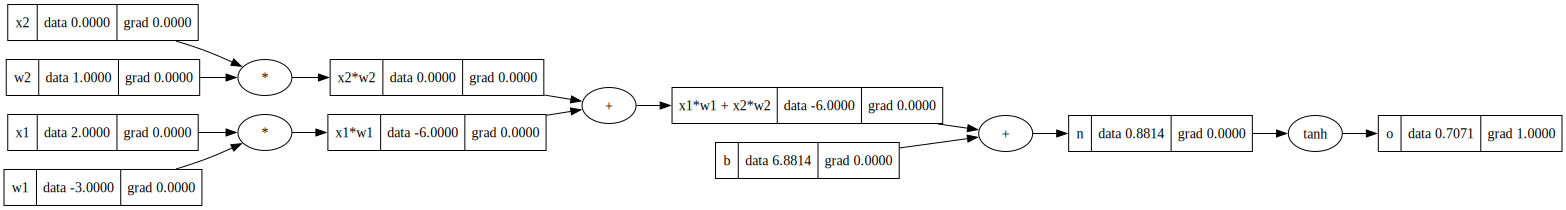

In [41]:
draw_dot(o)

In [42]:
o.data

0.7071067811865476

In [43]:
1 - o.data**2

0.4999999999999999

#### o = tanh(n)
#### do/dn = 1 - o**2

In [44]:
n.grad = 0.5

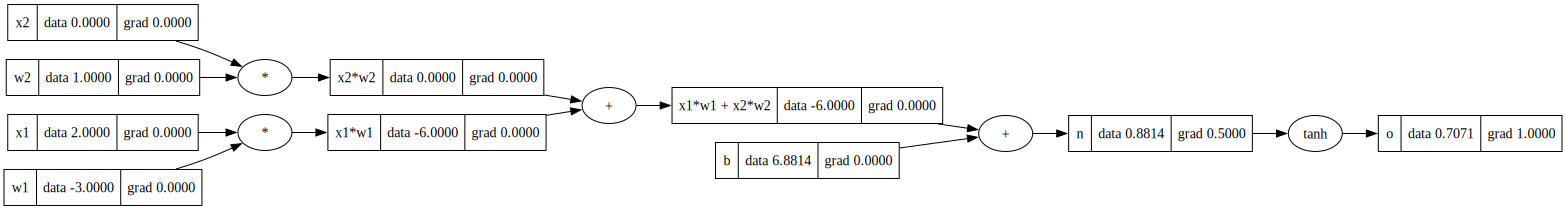

In [45]:
draw_dot(o)

#### We are working with a `+` node so therefore the `n.grad` of 0.5 will simply multiply by 1 or carry through.

In [46]:
x1w1x2w2.grad = 0.5

In [47]:
b.grad = 0.5

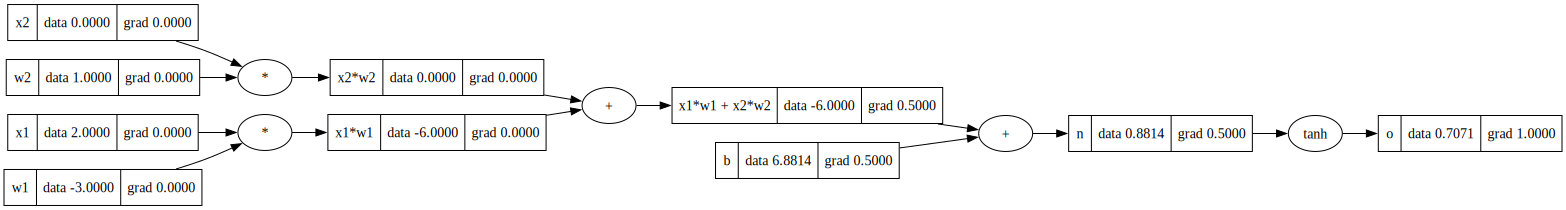

In [48]:
draw_dot(o)

#### We are working with a `+` node so therefore the `x1w1x2w2.grad` of 0.5 will simply multiply by 1 or carry through.

In [49]:
x2w2.grad = 0.5

In [50]:
x1w1.grad = 0.5

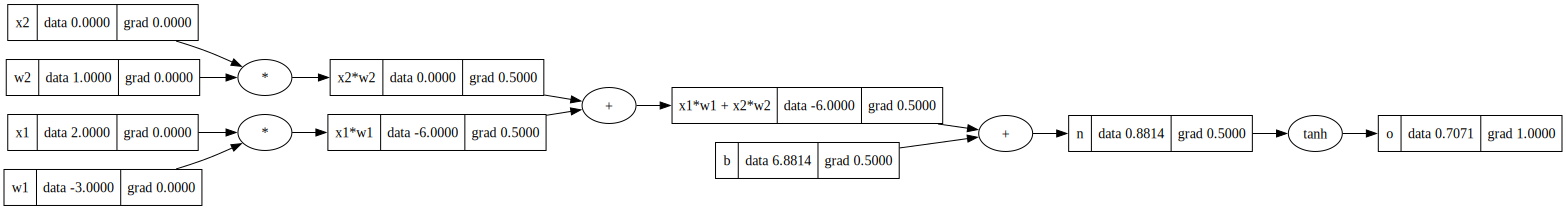

In [51]:
draw_dot(o)

#### We are working with a `*` node so therefore `x2.grad` will be `x2w2.grad * w2.data`. 

In [52]:
x2.grad = x2w2.grad * w2.data

In [53]:
w2.grad = x2w2.grad * x2.data

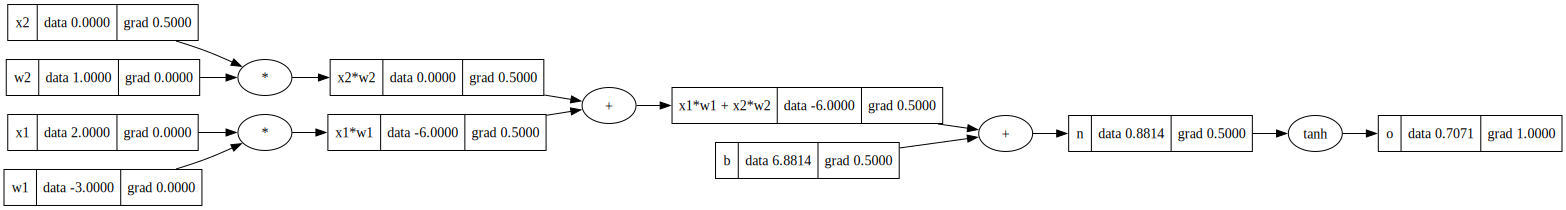

In [54]:
draw_dot(o)

In [55]:
x1.grad = x1w1.grad * w1.data

In [56]:
w1.grad = x1w1.grad * x1.data

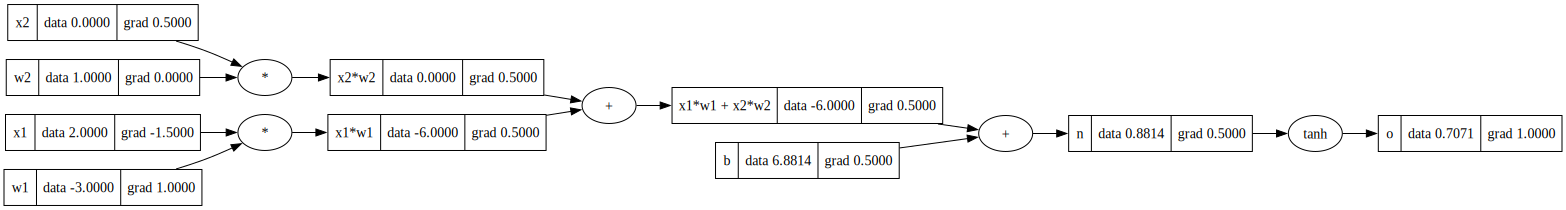

In [57]:
draw_dot(o)

### Manual Feed-Foward (1st Epoch)

In [58]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# activation function
o = n.tanh(); o.label = 'o'

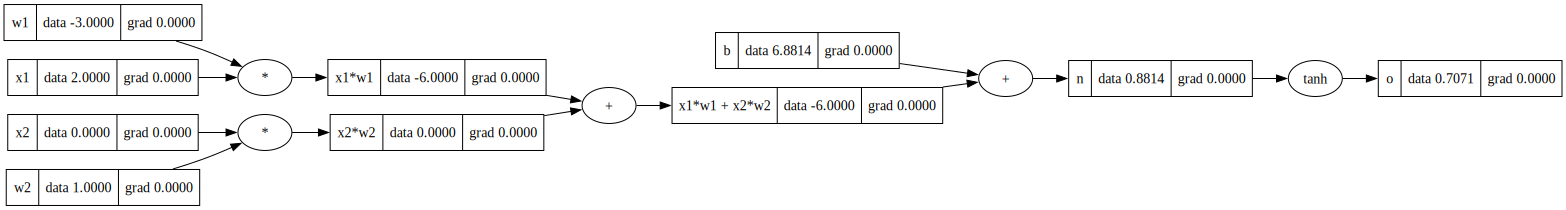

In [59]:
draw_dot(o)

### Back Propogation Step-By-Step (1st Epoch)

#### Base Case Init `o.grad` to 1.0

In [60]:
o.grad = 1.0

In [61]:
o._backward()

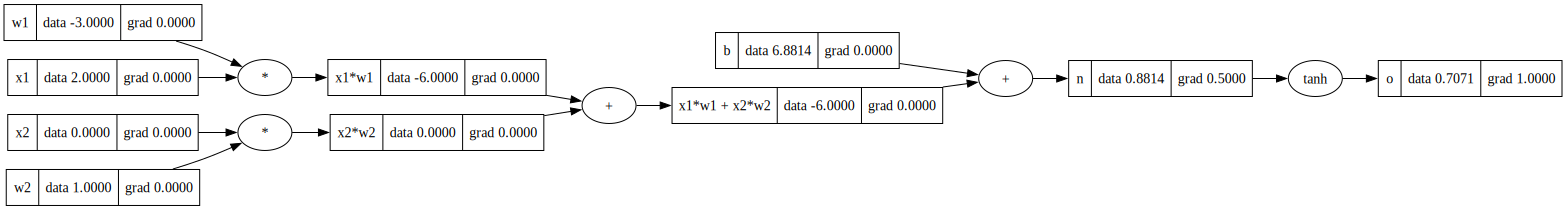

In [62]:
draw_dot(o)

In [63]:
n._backward()

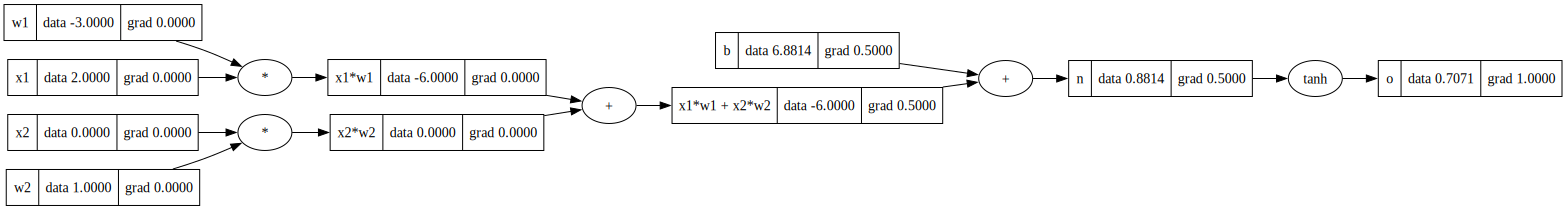

In [64]:
draw_dot(o)

In [65]:
b._backward()

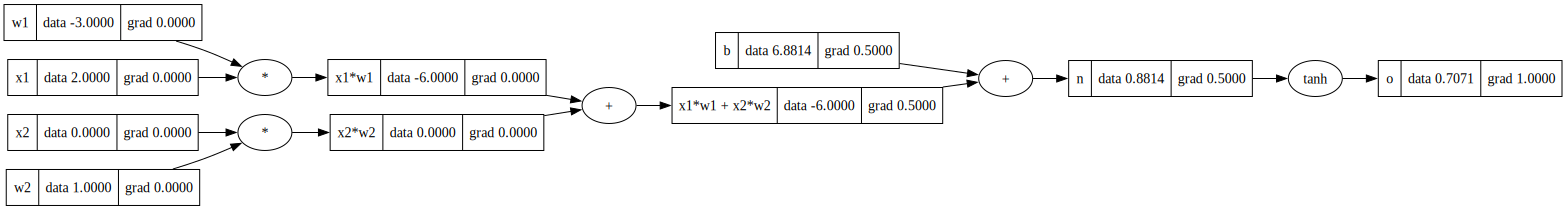

In [66]:
draw_dot(o)  # no change as b is not a leaf node

In [67]:
x1w1x2w2._backward()

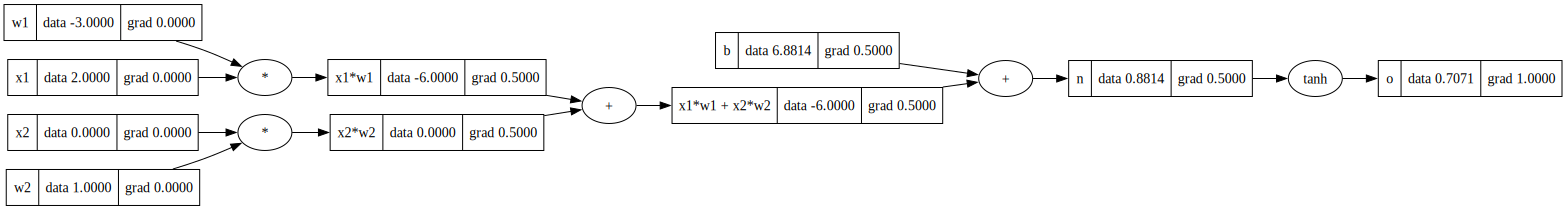

In [68]:
draw_dot(o)

In [69]:
x1w1._backward()

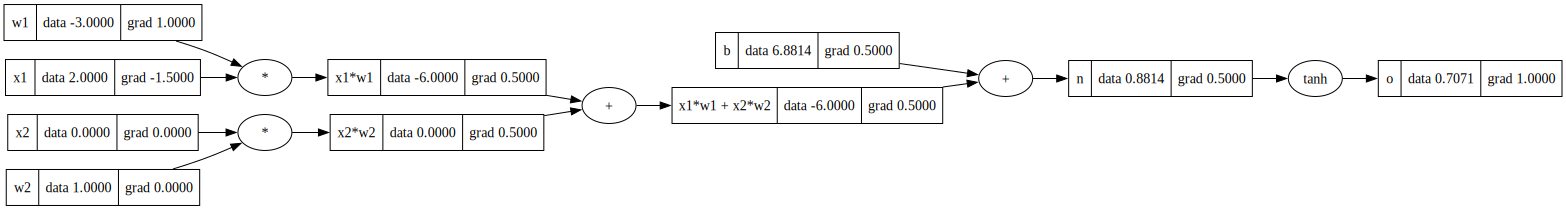

In [70]:
draw_dot(o)

In [71]:
x2w2._backward()

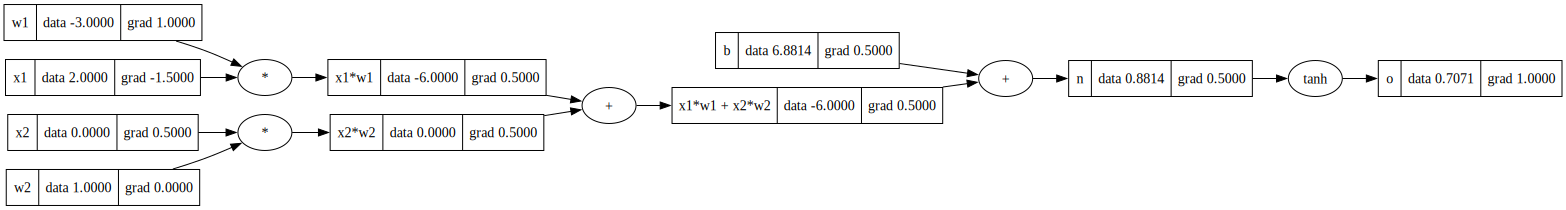

In [72]:
draw_dot(o)

### Manual Feed-Foward (1st Epoch)

In [73]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# activation function
o = n.tanh(); o.label = 'o'

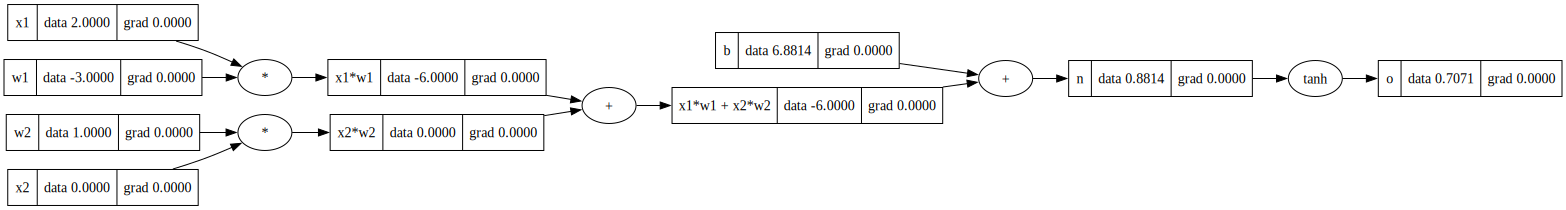

In [74]:
draw_dot(o)

### Back Propogation Topological Sort (1st Epoch)

#### Base Case Init `o.grad` to 1.0

In [75]:
o.grad = 1.0

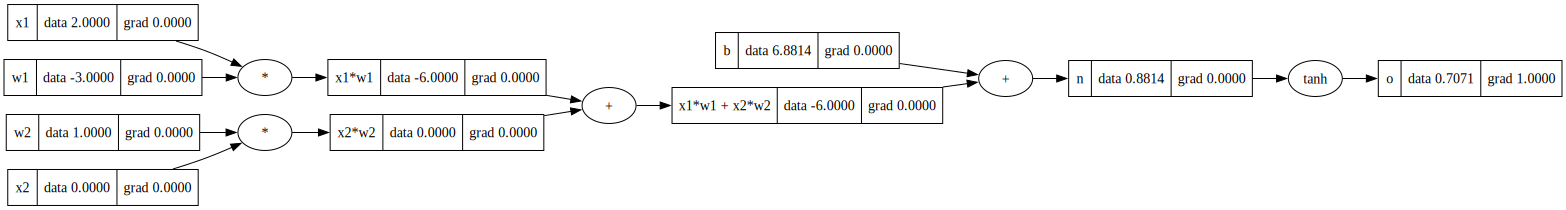

In [76]:
draw_dot(o)

In [77]:
o.backward()

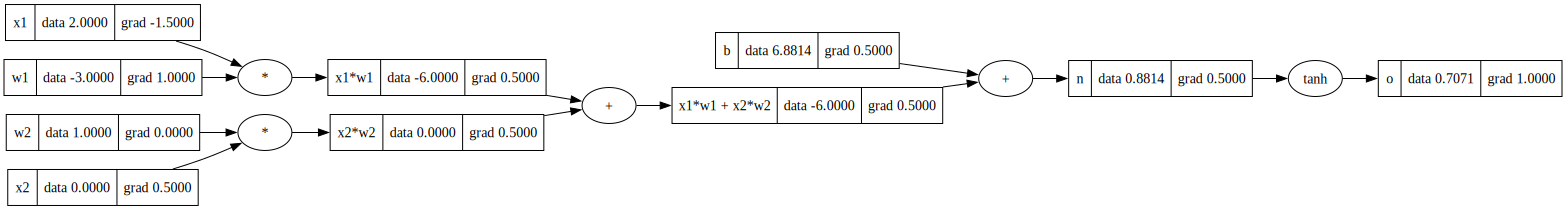

In [78]:
draw_dot(o)

## PyTorch Implementation

In [79]:
!pip install torch

#### Cast to `double` as Python default (double precision for floating-point as default is 32).
#### PyTorch does not assume leaf node so you must specify `requires_grad` on the leaf node.
#### We use `.item()` method in PyTorch to extract the value of a single-element tensor as a standard Python scalar.
#### The values below match our manual implementation.

In [80]:
import torch

In [81]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())

o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


#### 2x3 Tensor Object

In [82]:
torch.Tensor([
    [1, 2, 3],
    [4, 5, 6]
])

tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [83]:
torch.Tensor([
    [1, 2, 3],
    [4, 5, 6]
]).shape

torch.Size([2, 3])

In [84]:
torch.Tensor([
    [1, 2, 3],
    [4, 5, 6]
]).dtype

torch.float32

### Build a 2-layer MLP

### Explanation of the `__call__` Method

The `__call__` method performs the forward pass of a single neuron in a neural network. Below is a detailed explanation of the steps involved.

#### Inputs
- $x$: A list of input values for the neuron.
- The neuron is parameterized by:
  - **Weights ($w$)**: A set of learnable parameters, one weight for each input.
  - **Bias ($b$)**: A constant offset added to the weighted sum of inputs.

#### Computation Steps

1. **Weighted Sum Calculation**:
   The neuron calculates the weighted sum of its inputs and adds the bias:
   $$
   \text{act} = \sum_{i=1}^{n} w_i \cdot x_i + b
   $$
   This step involves pairwise multiplication of each input $x_i$ with its corresponding weight $w_i$, summing all the products, and adding the bias $b$.

2. **Activation Function**:
   The result of the weighted sum ($\text{act}$) is passed through the hyperbolic tangent activation function to introduce non-linearity:
   $$
   \text{out} = \tanh(\text{act})
   $$
   The $\tanh$ function squashes the output into the range $[-1, 1]$, enabling the neuron to model complex relationships.

#### Relationship to Matrix Multiplication

In larger neural networks, this operation generalizes to matrix multiplication:
- The inputs $x$ are represented as a vector.
- The weights $w$ are part of a weight matrix $W$, where each row corresponds to a neuron.
- The bias $b$ is a vector, where each element corresponds to a neuron.
- The computation becomes:
  $$
  \text{output} = \tanh(W \cdot x + b)
  $$
  Here, $W \cdot x$ performs a matrix-vector multiplication to compute the weighted sum for all neurons simultaneously.

#### Final Output
The result is the non-linear transformation of the inputs through the $\tanh$ activation function, producing the neuron's output.

In [96]:
class Neuron:
    """
    A single artificial neuron in a neural network.

    This class represents a single neuron with weights, a bias, and an activation function 
    (hyperbolic tangent, tanh). It computes the weighted sum of inputs plus the bias 
    and applies the activation function to produce an output.

    Attributes:
        w (list[Value]): List of weights for the neuron.
        b (Value): Bias of the neuron.
    """

    def __init__(self, nin):
        """
        Initializes the Neuron with random weights and bias.

        Args:
            nin (int): The number of inputs to the neuron.
        """
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        """
        Computes the forward pass of the neuron.

        Args:
            x (list[Value]): The input values for the neuron.

        Returns:
            Value: The output of the neuron after applying the tanh activation function.
        """
        # w * x + b
        # this is debug and will print the pairings
        # print(list(zip(x, self.w)))
        # print(self.b)
        
        # compute weighted sum of inputs plus bias
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()

        # return output from TANH activation function
        return out

    def parameters(self):
        """
        Returns the parameters of the neuron (weights and bias).

        Returns:
            list[Value]: A list of `Value` objects representing the weights and bias.
        """
        return self.w + [self.b]


class Layer:
    """
    A layer in a neural network, consisting of multiple neurons.

    Attributes:
        neurons (list[Neuron]): List of neurons in the layer.
    """

    def __init__(self, nin, nout):
        """
        Initializes the layer with a specified number of neurons.

        Args:
            nin (int): The number of inputs to each neuron in the layer.
            nout (int): The number of neurons in the layer.
        """
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        """
        Computes the forward pass of the layer.

        Args:
            x (list[Value]): The input values for the layer.

        Returns:
            Value or list[Value]: The output(s) of the layer. If the layer has a single neuron, 
                                  returns a single `Value`. Otherwise, returns a list of `Value` objects.
        """
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        """
        Returns the parameters of all neurons in the layer.

        Returns:
            list[Value]: A list of `Value` objects representing the parameters of all neurons.
        """
        return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:
    """
    A multi-layer perceptron (MLP) neural network.

    Attributes:
        layers (list[Layer]): List of layers in the MLP.
    """

    def __init__(self, nin, nouts):
        """
        Initializes the MLP with the specified number of layers and neurons.

        Args:
            nin (int): The number of inputs to the MLP.
            nouts (list[int]): A list where each element represents the number of neurons 
                               in each subsequent layer.
        """
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

    def __call__(self, x):
        """
        Computes the forward pass of the MLP.

        Args:
            x (list[Value]): The input values for the MLP.

        Returns:
            Value or list[Value]: The output(s) of the MLP. If the final layer has a single neuron, 
                                  returns a single `Value`. Otherwise, returns a list of `Value` objects.
        """
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        """
        Returns the parameters of all layers in the MLP.

        Returns:
            list[Value]: A list of `Value` objects representing the parameters of all layers.
        """
        return [p for layer in self.layers for p in layer.parameters()]

In [97]:
# example usage:

# create a neuron with 3 inputs
neuron = Neuron(nin=3)  # initialize with the number of inputs

# inputs to the neuron
inputs = [Value(1.0), Value(-2.0), Value(3.0)]

# forward pass
output = neuron(inputs)
print(f'neuron output: {output}')

neuron output: Value(data=-0.8788926416239834)


In [98]:
neuron.parameters()

[Value(data=-0.3064275960721512),
 Value(data=0.6312472193736445),
 Value(data=-0.23192278183219517),
 Value(data=0.8938101551411495)]

In [99]:
neuron.w

[Value(data=-0.3064275960721512),
 Value(data=0.6312472193736445),
 Value(data=-0.23192278183219517)]

In [100]:
neuron.b

Value(data=0.8938101551411495)

### Layer of Neurons

In [101]:
x = [2.0, 3.0]
n = Layer(2, 3)
n(x)

[Value(data=-0.35533058901900183),
 Value(data=0.8897912088839817),
 Value(data=-0.5996979054580914)]

### Multi-Layer Perceptron

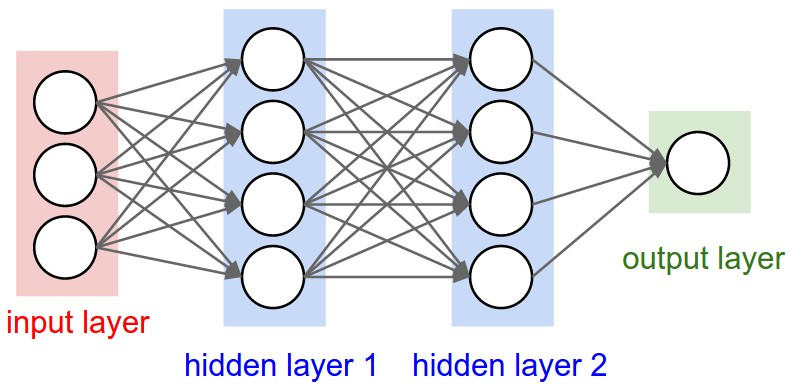

In [102]:
Image(filename = 'neural_net.jpeg', width=600)

#### Photo Credit: [CS231n Convolutional Neural Networks for Visual Recognition](https://cs231n.github.io/neural-networks-1) 

In [103]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.8723284194237442)

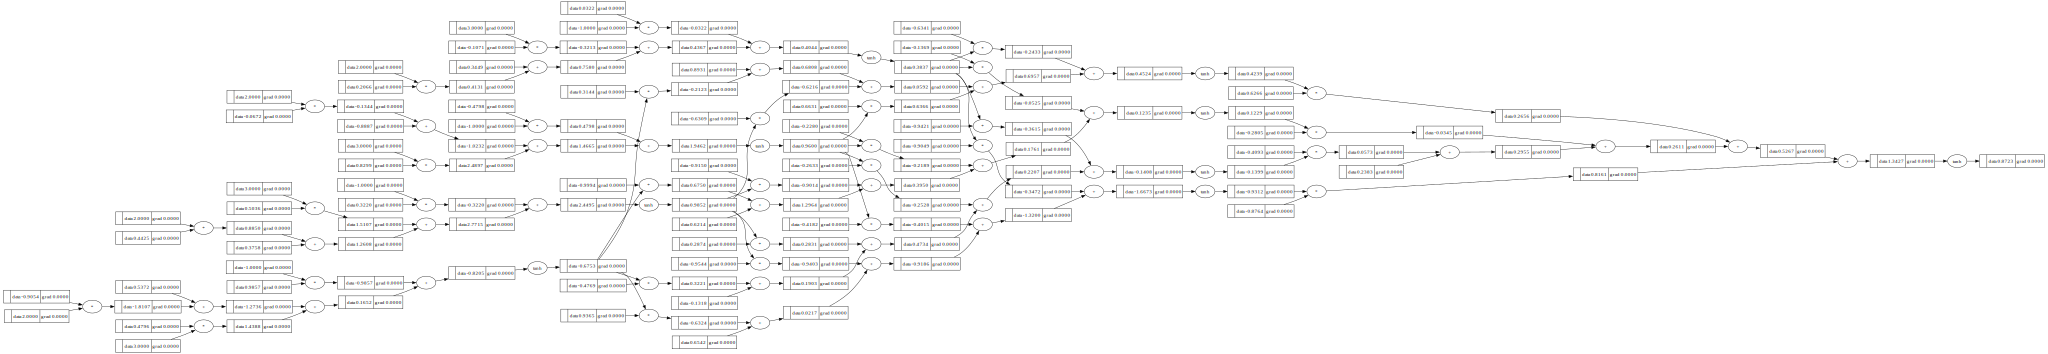

In [104]:
draw_dot(n(x))

### Simple Binary Classifier

#### First pred is 0.94 but we want 1.0, second pred is -0.93 but we want -1.0, third pred is -0.93 but we want -1.0 and finally the fourth pred is 0.92 but we want 1.0.

In [109]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets

ypred = [n(x) for x in xs] # predicted targets
ypred

[Value(data=0.9441717445972383),
 Value(data=-0.9365348993061496),
 Value(data=-0.937730583324505),
 Value(data=0.9208482557676855)]

In [152]:
xs = [
  [1.0, 3.0, -1.0]
]

ys = [1.0] # desired targets

ypred = [n(x) for x in xs] # predicted targets
ypred

[Value(data=0.9356092946177663)]

#### How do we tune the weights to better predict the desired targets?
#### We will calculate a single number that measures the total performance of the neural net.
#### This single number is called the `loss`
#### We will work with the MSE or mean squared error loss.
#### We will pair up the ground truths w/ the predictions and the zip iterates over tuples of them.
#### We will subtract `yout` and `ygt` and square them as we do not want negative loss.
#### If `yout - ygt` we have 0 or perfect prediction otherwise we have a loss.

In [153]:
[(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]

[Value(data=0.004146162939621618)]

In [154]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

In [155]:
loss

Value(data=0.004146162939621618)

### GOAL: Minimize Loss

#### We see the grad is negative so the influence on the loss is also negative.

In [156]:
loss.backward()

In [157]:
n.layers[0].neurons[0].w[0]

Value(data=-0.8578937671461817)

In [158]:
n.layers[0].neurons[0].w[0].data

-0.8578937671461817

In [159]:
n.layers[0].neurons[0].w[0].grad

0.11388022817127133

#### NOTE: The grad on the input data is not useful as it is a fixed input.

In [160]:
# draw_dot(loss)

In [161]:
n.parameters()

[Value(data=-0.8578937671461817),
 Value(data=0.5228697367708208),
 Value(data=0.9735117906939498),
 Value(data=0.5632261667843647),
 Value(data=0.3550972421392825),
 Value(data=0.5003620856380782),
 Value(data=0.33678666679186187),
 Value(data=0.3313436944968348),
 Value(data=0.049078766900115096),
 Value(data=0.9369933313021306),
 Value(data=-0.9657263146395968),
 Value(data=-0.8430634665430564),
 Value(data=-0.09825771807511521),
 Value(data=0.015305247956594608),
 Value(data=-0.16349349735835528),
 Value(data=0.20569174531879172),
 Value(data=-0.413371121138832),
 Value(data=0.38339664874811585),
 Value(data=-0.5274538790535002),
 Value(data=-0.853871658128329),
 Value(data=-0.03373842975017331),
 Value(data=-0.9531325422832749),
 Value(data=-0.9126101545111202),
 Value(data=-0.35014811666559015),
 Value(data=-0.11182420465098428),
 Value(data=0.6180204536888522),
 Value(data=0.06325002357241893),
 Value(data=-0.7488287825343546),
 Value(data=1.1009751724742605),
 Value(data=-0.705

In [162]:
len(n.parameters())

41

#### In gradient descent for p in n.parameters() all 41 params we want to change p.data depending on the grad info.
#### In gradient descent we are thinking of the gradient as a vector pointing in the direction of increased loss.
#### In gradient descent we are modifying p.data by a small step size in the direction of the gradient so the step size can be a very small number like 0.01 and multiply by p.grad.
#### We need to think through some of the signs so in particular working with this specific example here we see if we left it like original, the neuron's value would be currently increased by a tiny amount of the gradient 0.11 and here the gradient is positive so the value of the neuron would go slightly up so something like -0.859 instead of -0.857. 
#### If we nudge all the params by a tiny amount we will see the data has changed so the loss will go down.
#### If you have too large a learning rate you may overstep and increase the loss.
#### If the LR is too low it may take significant time to converge. TODO show this below

In [168]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [169]:
n.layers[0].neurons[0].w[0].data

-0.8601713717096071

In [170]:
n.layers[0].neurons[0].w[0].grad

0.11388022817127133

#### Old Value `Value(data=0.004146162939621618)`

In [171]:
ypred = [n(x) for x in xs] # predicted targets
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=0.0004347066769787088)

In [172]:
for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)

0 0.0004347066769787088
1 0.00042989336248052247
2 0.0004252104862988657
3 0.0004206525686584696
4 0.00041621443795442206
5 0.0004118912091916851
6 0.0004076782642195503
7 0.0004035712335885176
8 0.00039956597987575394
9 0.0003956585823417438
10 0.0003918453227954237
11 0.0003881226725576694
12 0.00038448728042457563
13 0.0003809359615418036
14 0.00037746568711025764
15 0.00037407357485130105
16 0.0003707568801665672
17 0.00036751298793394625
18 0.00036433940488663977
19 0.00036123375252743373


In [174]:
ypred

[Value(data=0.9809938496131533)]

In [5]:
import torch

# Initialize inputs, weights, and bias
x1 = torch.tensor([2.0], dtype=torch.double, requires_grad=True)
x2 = torch.tensor([0.0], dtype=torch.double, requires_grad=True)
w1 = torch.tensor([-3.0], dtype=torch.double, requires_grad=True)
w2 = torch.tensor([1.0], dtype=torch.double, requires_grad=True)
b = torch.tensor([6.8813735870195432], dtype=torch.double, requires_grad=True)

# Hyperparameters
learning_rate = 0.01  # Learning rate for gradient descent
epochs = 20          # Number of epochs

# Target value for loss calculation (desired output)
target = torch.tensor([0.0], dtype=torch.double)

# Training loop
for epoch in range(epochs):
    # Forward pass
    n = x1 * w1 + x2 * w2 + b  # Linear combination
    o = torch.tanh(n)          # Activation function
    
    # Loss calculation (Mean Squared Error for simplicity)
    loss = (o - target).pow(2) / 2  # MSE: L = (1/2) * (o - target)^2

    # Backward pass
    loss.backward()  # Compute gradients
    
    # Gradient descent step (manual weight updates)
    with torch.no_grad():
        w1 -= learning_rate * w1.grad
        w2 -= learning_rate * w2.grad
        b -= learning_rate * b.grad

        # Zero gradients for next iteration
        w1.grad.zero_()
        w2.grad.zero_()
        b.grad.zero_()
        x1.grad.zero_()
        x2.grad.zero_()
    
    # Print loss for each epoch
    print(f"Epoch {epoch + 1}, Loss: {loss.item():.6f}, Output: {o.data.item():.6f}")

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
Epoch 1, Loss: 0.250000, Output: 0.707107
Epoch 2, Loss: 0.243712, Output: 0.698157
Epoch 3, Loss: 0.237271, Output: 0.688870
Epoch 4, Loss: 0.230684, Output: 0.679241
Epoch 5, Loss: 0.223958, Output: 0.669265
Epoch 6, Loss: 0.217101, Output: 0.658939
Epoch 7, Loss: 0.210122, Output: 0.648262
Epoch 8, Loss: 0.203034, Output: 0.637235
Epoch 9, Loss: 0.195850, Output: 0.625859
Epoch 10, Loss: 0.188585, Output: 0.614142
Epoch 11, Loss: 0.181256, Output: 0.602090
Epoch 12, Loss: 0.173882, Output: 0.589714
Epoch 13, Loss: 0.166481, Output: 0.577028
Epoch 14, Loss: 0.159075, Output: 0.564049
Epoch 15, Loss: 0.151687, Output: 0.550795
Epoch 16, Loss: 0.144340, Output: 0.537289
Epoch 17, Loss: 0.137056, Output: 0.523557
Epoch 18, Loss: 0.129860, Output: 0.509627
Epoch 19, Loss: 0.122774, Output: 0.495529
Epoch 20, Loss: 0.115823, Output: 0.48

Exception ignored in atexit callback: <bound method InteractiveShell.atexit_operations of <ipykernel.zmqshell.ZMQInteractiveShell object at 0x105da4ef0>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/prod/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3952, in atexit_operations
    self._atexit_once()
  File "/opt/anaconda3/envs/prod/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3935, in _atexit_once
    self.history_manager.end_session()
  File "/opt/anaconda3/envs/prod/lib/python3.12/site-packages/IPython/core/history.py", line 594, in end_session
    self.db.execute(
sqlite3.OperationalError: attempt to write a readonly database
